deep100m.base.M_32.efc_1000.efs_1000.ck_ts_0.ncheck_100.recall@1000.nthread_48.random.log
deep100m.base.M_32.efc_1000.efs_1000.ck_ts_0.ncheck_100.recall@1000.nthread_48.random.log
(1.00 34.21), (1.00 33.76), (1.00 33.00), (1.00 32.28), (1.00 31.75), (1.00 30.86), (1.00 30.28), (1.00 29.59), (1.00 28.91), (1.00 28.07), (1.00 27.29), (1.00 26.78), (0.99 26.01), (0.99 25.41), (0.99 24.63), (0.99 24.01), (0.99 23.35), (0.99 22.75), (0.99 21.85), (0.99 21.57), (0.99 20.56), (0.99 19.96), (0.99 19.31), (0.99 18.62), (0.99 17.91), (0.99 17.03), (0.99 16.57), (0.99 15.89), (0.99 14.71), (0.99 13.66), (0.99 13.03), (0.99 12.35), (0.99 12.02), (0.99 11.27), (0.98 10.41), (0.98 9.58), (0.98 9.10), (0.98 8.41), (0.98 7.67), (0.98 6.88), (0.98 6.01), (0.98 5.68), (0.98 4.93), (0.98 4.19), (0.98 3.34), (0.98 2.69), (0.98 2.50), (0.98 1.97), deep100m.base.M_32.efc_1000.efs_1000.ck_ts_0.ncheck_100.recall@1000.thr_980.nthread_48.qonly.log
deep100m.base.M_32.efc_1000.efs_1000.ck_ts_0.ncheck_100.recall@1

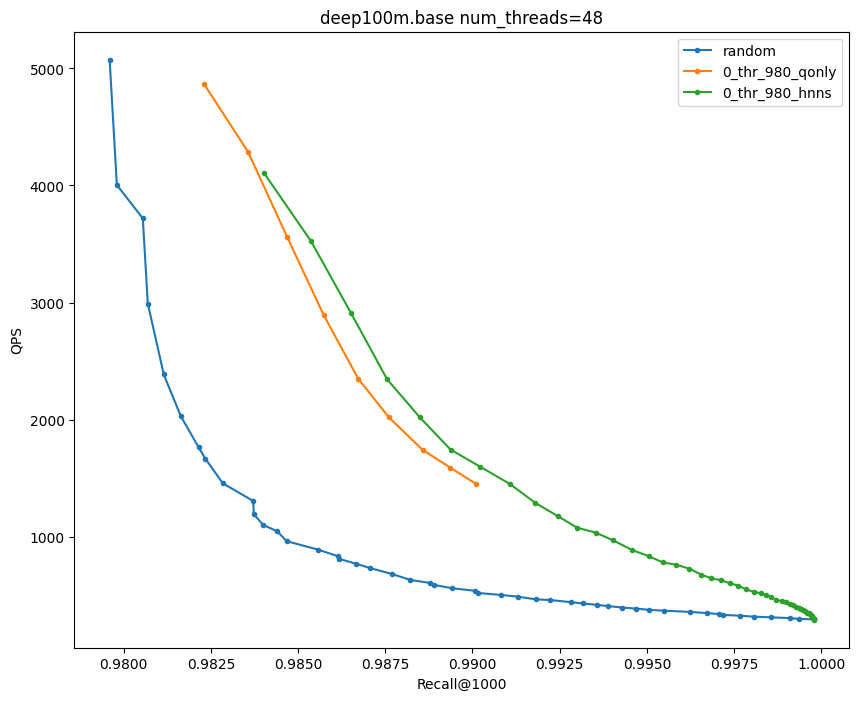

In [7]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt

dataset = 'imagenet.base'
dataset = 'datacomp-image.base'
dataset = 'wikipedia.base'
dataset = 'deep100m.base'
log_path = "/home/zhengweiguo/liuchengjun/HybridNNS/log/"
config = json.loads(open('config.json').read())
M, efs = config[dataset]["M"], config[dataset]["efs"]
thrs = config[dataset]["thresholds"]
dim = config[dataset]["dim"]
efc = 1000
ck_ts = 0
k = 1000

num_threads = 48
plt.figure(figsize=(10, 8))

def get_recall_time(prefix):
    print(prefix)
    recall_time = []
    logfile_path = os.path.join(log_path, prefix)
    if os.path.exists(logfile_path) == False:
        print(f'{logfile_path} does not exist')
        return
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        curr = []
        for line in lines:
            if 'model_path' in line: continue
            if 'E2E time: ' in line:
                curr.append(float(line.split(': ')[1]))
            elif f'Recall@{k}' in line:
                avg = np.mean(curr)
                curr.clear()
                curr.append(avg)
                curr.append(float(line.split(': ')[1]))
                recall_time.append((curr[1], curr[0]))
                curr = []
                
    def pareto_frontier(points):
        # Sort the points by recall (descending) then by E2E time (ascending)
        points = sorted(points, key=lambda x: (-x[0], x[1]))
        frontier = []
        for point in points:
            if len(frontier) == 0 or point[1] < frontier[-1][1]:
                frontier.append(point)
        return frontier
    
    recall_time = pareto_frontier(recall_time)
    print(prefix)
    for recall, time in recall_time:
        print(f'({recall:.2f} {time:.2f})', end=', ')
    plt.plot([x[0] for x in recall_time], [10000 / x[1] for x in recall_time], '.-')
    return recall_time

legends = []

method = 'random'
prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}.nthread_{num_threads}.{method}.log'
recall_time_random = get_recall_time(prefix)
legends.append(f'{method}')

method = 'qonly'
for thr in thrs:
    prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}.thr_{thr}.nthread_{num_threads}.{method}.log'
    recall_time_hnns_optimized_ck_ts_1000 = get_recall_time(prefix)
    legends.append(f'{ck_ts}_thr_{thr}_{method}')


# method = 'hnns_full'
# ck_ts = 0
# thr = 700
# prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}.thr_{thr}.nthread_{num_threads}.{method}.log'
# recall_time_hnns = get_recall_time(prefix)
# legends.append(f'{ck_ts}_{method}')

method = 'hnns'
for thr in thrs:
    prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}.thr_{thr}.nthread_{num_threads}.{method}.log'
    recall_time_hnns = get_recall_time(prefix)
    legends.append(f'{ck_ts}_thr_{thr}_{method}')

print(legends)


# ax1 = plt.axes([0.1, 0.1, 0.8, 0.8])  # [left, bottom, width, height]
# plt.plot([x[0] for x in recall_time_hnns], [10000 / x[1] for x in recall_time_hnns], 'b*-')
# plt.plot([x[0] for x in recall_time_hnns_optimized], [10000 / x[1] for x in recall_time_hnns_optimized], 'g*-')
plt.legend(legends)
# plt.legend(['random', 'hnns'])
plt.xlabel(f'Recall@1000')
plt.title(f'{dataset} num_threads={num_threads}')
plt.ylabel('QPS')

# ax2 = plt.axes([0.05, 0.6, 0.2, 0.3])  # [left, bottom, width, height]，放置在左上角
# x_zoom_random = [x for x in recall_time_random if 0.998 <= x[0] <= 1.000]
# x_zoom_hnns = [x for x in recall_time_hnns if 0.998 <= x[0] <= 1.000]
# plt.plot([x[0] for x in x_zoom_random], [10000 / x[1] for x in x_zoom_random], 'r*-')
# plt.plot([x[0] for x in x_zoom_hnns], [10000 / x[1] for x in x_zoom_hnns], 'b*-')

plt.show()